In [1]:
import btrdb
import pandas as pd
import numpy as np

from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from btrdb.utils import timez

db = btrdb.connect()

In [2]:
def plot_aggregates(df, vlines=[], hlines=[]):
    fig, ax = plt.subplots(figsize=(15,3))
    df['min'].plot(ax=ax, ls=' ', marker='_', color='black', markersize=5, label='minimum')
    df['max'].plot(ax=ax, ls=' ', marker='_', color='black', markersize=5, label='maximum')
    df['mean'].plot(ax=ax, label='average', ls=' ', marker='.')
    ax.fill_between(df.index, df['mean']-df['stddev'], df['mean'] + df['stddev'], alpha=0.5, label=r'$+/- 1\times\sigma$')
    plt.legend()

    ax.vlines(vlines, *ax.get_ylim(), color='0.5', alpha=0.5, zorder=10, lw=3, label='events')
    ax.hlines(hlines, *ax.get_xlim(), color='0.5', zorder=10, lw=1, ls='--', label='threshold')
    return fig
    
def points_to_dataframe(points, 
                        aggregates=['time','min','max','mean','stddev','count'],
                        use_datetime_index=True):
    df = pd.DataFrame([[getattr(p, agg) for agg in aggregates] for p in points],
                         columns=aggregates)
    if use_datetime_index:
        df['datetime'] = [timez.ns_to_datetime(t) for t in df.time]
        df = df.set_index('datetime')
    return df

In [3]:
NOMINAL = 7150
THRESHOLD = 0.05

####################
# Event Indicators 

def is_overvoltage(point, threshold=THRESHOLD, nominal=NOMINAL):
    return point.max > nominal*(1+threshold)

def is_undervoltage(point, threshold=THRESHOLD, nominal=NOMINAL):
    return point.min < nominal*(1-threshold)


####################
# Helper functions 

def pw_to_time(pw):
    if type(pw) != btrdb.utils.general.pointwidth:
        pw = btrdb.utils.general.pointwidth(pw)
    return pd.Timedelta(pw.nanoseconds, unit='ns')

def time_to_pw(time):
    ns = 1e9*time.total_seconds() # convert to nanoseconds
    return btrdb.utils.general.pointwidth(np.log2(ns))

def int_to_pw(pw):
    return btrdb.utils.general.pointwidth(pw)



In [4]:
streams = db.streams_in_collection('sunshine/PMU1', tags={'unit': 'volts'})

pd.DataFrame([[s.name, s.unit, s.collection] for s in streams],
            columns=['name','unit','collection'])

stream = db.stream_from_uuid(streams[1].uuid)

start_time = datetime(2016,4,1)
end_time = datetime(2017,4,1)

start_ns = timez.datetime_to_ns(start_time)
end_ns = timez.datetime_to_ns(end_time)

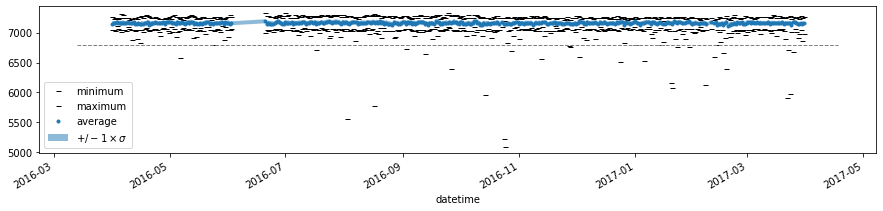

In [5]:
window = timez.ns_delta(days=1)
pw = int(np.log2(window))

points, _ = zip(*stream.aligned_windows(start_ns, end_ns, pointwidth=pw))
df = points_to_dataframe(points)
fig = plot_aggregates(df, hlines=NOMINAL*(1-THRESHOLD))

# Narrowing in on sag events

Plotting aggregates above gives a high level view indicating on what days undervoltage events were observed. These graphs do not tell us, however, how many undervoltage events may have occurred on each day. Here, we'll drill down to narrower time windows to create a library of individual events.

We'll start by defining some threshold $tau$ which characterizes an undervoltage event; here, voltage sags are defined as intervals where the voltage falls below 0.9 per unit (or 10% below nominal). 

We'll begin by examining StatPoints at a high level in the tree. A pointwidth $pw=46$ is equivalent to about 19.5 hours or a little under one day. We'll keep a record of each day where the minimum voltage falls below the threshold $tau$, and will then decrease the pointwidth with each iteration to determine when (to the nearest minute) undervoltage events occurred. 

In [6]:
pw = 46
NOMINAL = 7.15e3
THRESHOLD = 0.1
tau = NOMINAL * (1 - THRESHOLD)

pw_to_time(pw)

Timedelta('0 days 19:32:48.744177664')

In [7]:

points, _ = zip(*stream.aligned_windows(start_ns, end_ns, pointwidth=pw))
points = pd.DataFrame([(pt.time, pt.min, pw) for pt in points],
                        columns=['time','minimum','pointwidth'])

sag_points = points[points['minimum'] < tau]

t0 = datetime.now()
while pw > time_to_pw(timedelta(minutes=1)):
    pw = pw - 2
    
    _sag_points = []
    for i, row in sag_points.iterrows():
        _start_ns = row['time']
        _end_ns = row['time'] + 1.25*int_to_pw(row['pointwidth']).nanoseconds
        points, _ = zip(*stream.aligned_windows(_start_ns, _end_ns, pointwidth=pw-2))
        points = pd.DataFrame([(pt.time, pt.min, pw) for pt in points],
                        columns=['time','minimum','pointwidth'])

        idx = points['minimum'] < tau
        if any(idx):
            _sag_points.append(points.loc[idx])
        else:
            print('No sags found.\n')
        
    sag_points = pd.concat(_sag_points).reset_index()
    
print(len(sag_points), 'voltage sags detected.')
print(str(datetime.now()-t0))


47 voltage sags detected.
0:00:00.825464


# Compute sag characteristics (start time, depth, duration)

In [8]:
sags_info = pd.DataFrame(columns=['start','end','depth'],
                       index=sag_points.index)

sags_data = []

t0 = datetime.now()
for i, row in sag_points.iterrows():
    _start_ns = row['time'] - 1e9*10
    _end_ns = row['time'] + 1e9*10 + 2**int(row['pointwidth'])
    
    points, _ = zip(*stream.values(_start_ns, _end_ns))
    df = pd.DataFrame([(p.time, p.value) for p in points],
                      columns=['time','value'],
                     ).set_index('time')
    
    sag = df.loc[df['value'] <= tau]
    
    sags_info.iloc[i] = {'start': sag.index.min(), 
                        'end': sag.index.max(), 
                        'depth': sag.min()}
    
    if len(sags_data) < 20:
        sags_data.append(df)
    
sags_info['duration'] = (sags_info['end'] - sags_info['start'])/1e9
print(str(datetime.now()-t0))

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0:00:02.167172


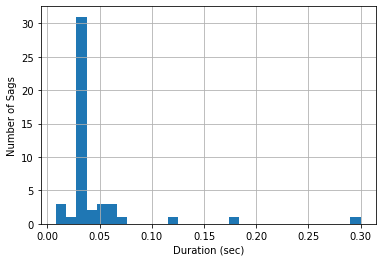

In [9]:
sags_info['duration'].hist(bins=30)
plt.xlabel('Duration (sec)')
plt.ylabel('Number of Sags')
plt.show()

# Show examples of voltage sags

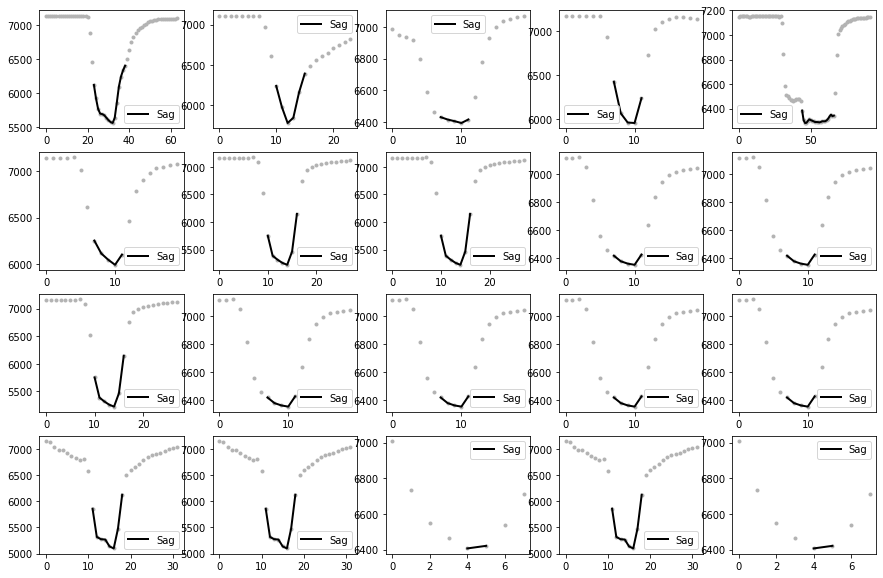

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))

for i, _ax in enumerate(ax.flatten()):
    ts = sags_data[i].reset_index()
    
    min_ix = ts['value'].idxmin()

    idx = ts['value'] <= tau
    ts = ts.iloc[min_ix-2*sum(idx):min_ix+2*sum(idx)]
    ts = ts.reset_index()

    ts.plot(y='value', color='0.7', lw=1, ax=_ax, ls=' ', marker='.', legend=None)
    ts[ts['value'] <= tau].plot(y='value', color='k', lw=2, ax=_ax, label='Sag')

fig.subplots_adjust(wspace=0.2)
plt.show()